# Transfer Learning

## Setup



*   We import all the necessary libraries and dependencies.
*   We make sure to mount the google drive (as using google collab).




In [20]:
# Data processing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Deep learning libraries

import keras
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image as Image

# Utils libraries

import kagglehub
import time
import random
import datetime

# Google drive

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

#drive.mount('/content/drive')



*   Then, we make sure to download the latest dataset version.
*   We are using the animal 10 dataset.



In [21]:
# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)
DATASET_URI= path + "/raw-img"
print("Path to dataset files:", DATASET_URI)

Path to dataset files: /kaggle/input/animals10
Path to dataset files: /kaggle/input/animals10/raw-img


## Data preprocessing



*   We determine standard values for our images.
*   For this transfer learning, we use the same values as the ones used for our 5th model.
* We construct our training and testing dataset




In [24]:

random.seed(10)
batch_size = 32 # Batch size increase to 64
img_height = 180
img_width = 180
img_size = (img_height, img_width)
seed = random.randint(1, 200)

train_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

test_ds = keras.utils.image_dataset_from_directory(
  directory=DATASET_URI,
  validation_split=0.1,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True
)

# We print the class names for double check.

print(f"Training classes => {train_ds.class_names}")
print(f"Testing classes => {test_ds.class_names}")


Found 26179 files belonging to 10 classes.
Using 23562 files for training.
Found 26179 files belonging to 10 classes.
Using 2617 files for validation.
Training classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Testing classes => ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']




*  We convert the names from italian to English.






In [27]:

italian_to_english = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'ragno': 'spider',
    'scoiattolo': 'squirrel'
}

class_names = np.array([italian_to_english[name] for name in train_ds.class_names])
num_classes = len(class_names)

print("class_names => ", class_names)
print("num_classes => ", num_classes)

class_names =>  ['dog' 'horse' 'elephant' 'butterfly' 'chicken' 'cat' 'cow' 'sheep'
 'spider' 'squirrel']
num_classes =>  10




*   We normalize our images




In [29]:
normalization_layer = keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.



*   We cache our data to lower the IO costs



In [30]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)



*   We double check the shape of our data




In [31]:

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


## Load pre trained VGG16 model

In [32]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.trainable = False  # Freeze the base model layers

* Add custom classification layers

In [33]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])



*   Compile the model


In [35]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

* Train the modelo

In [37]:
callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CNN_Image_classification/feature_learning_Mo_at_{epoch}.keras"), keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25,
    batch_size=batch_size,
    callbacks=callbacks

)

Epoch 1/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.5208 - loss: 1.5060 - val_accuracy: 0.6003 - val_loss: 1.3655
Epoch 2/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.5555 - loss: 1.4254 - val_accuracy: 0.6232 - val_loss: 1.2905
Epoch 3/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.5687 - loss: 1.3555 - val_accuracy: 0.6473 - val_loss: 1.2300
Epoch 4/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.5931 - loss: 1.2985 - val_accuracy: 0.6630 - val_loss: 1.1802
Epoch 5/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.6080 - loss: 1.2598 - val_accuracy: 0.6790 - val_loss: 1.1383
Epoch 6/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.6169 - loss: 1.2191 - val_accuracy: 0.6878 - val_loss: 1.1030
Epoch 7/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.6299 - loss: 1.1905 - val_accuracy: 0.6993 - val_loss: 1.0728
Epoch 8/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 43s 59ms/step - accuracy: 0.6335 - loss: 1.1644 - 

In [38]:
model.save("/content/drive/MyDrive/CNN_Image_classification/feature_learning_Mo_.keras")

In [39]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


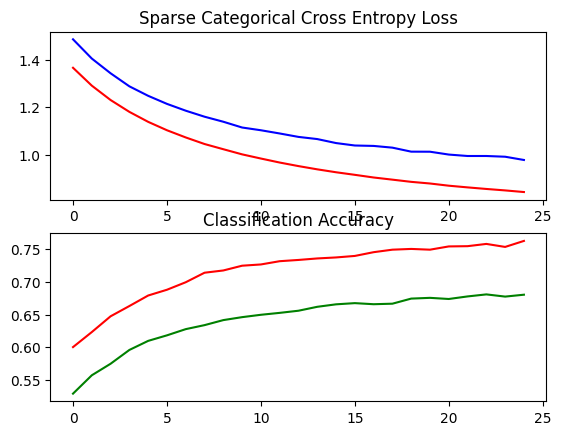

In [40]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val')
plt.show()

Evaluate

In [41]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.7512 - loss: 0.8532
Test Accuracy: 0.762323260307312


## Fine tunning

Unfreeze some layers from model base

In [42]:
base_model.trainable = True

freeze everything but the last 4

In [43]:
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [44]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # més petit!
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [46]:

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CNN_Image_classification/feature_learning_finetune_Mo_at_{epoch}.keras"), keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
]
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=25,
    batch_size=batch_size,
    callbacks=callbacks

)

Epoch 1/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 49s 66ms/step - accuracy: 0.8837 - loss: 0.3522 - val_accuracy: 0.8949 - val_loss: 0.3348
Epoch 2/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 48s 65ms/step - accuracy: 0.9063 - loss: 0.2961 - val_accuracy: 0.8987 - val_loss: 0.3232
Epoch 3/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 48s 65ms/step - accuracy: 0.9162 - loss: 0.2561 - val_accuracy: 0.9029 - val_loss: 0.3060
Epoch 4/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - accuracy: 0.9274 - loss: 0.2229 - val_accuracy: 0.9075 - val_loss: 0.2971
Epoch 5/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 48s 65ms/step - accuracy: 0.9401 - loss: 0.1894 - val_accuracy: 0.9064 - val_loss: 0.2937
Epoch 6/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - accuracy: 0.9475 - loss: 0.1652 - val_accuracy: 0.9125 - val_loss: 0.2828
Epoch 7/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 48s 65ms/step - accuracy: 0.9579 - loss: 0.1408 - val_accuracy: 0.9133 - val_loss: 0.2847
Epoch 8/25
737/737 ━━━━━━━━━━━━━━━━━━━━ 48s 65ms/step - accuracy: 0.9592 - loss: 0.1265 - 

In [47]:
model.save("/content/drive/MyDrive/CNN_Image_classification/learning_transfer_finetune_Mo_learning_transfer.keras")

Evaluate

In [48]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9218 - loss: 0.2533
Test accuracy: 0.9163


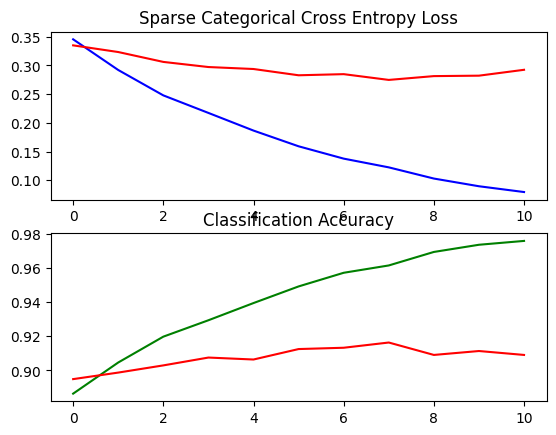

In [49]:
plt.subplot(211)
plt.title('Sparse Categorical Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='val')

# plot accuracy
plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val')
plt.show()

In [50]:


for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = tf.argmax(predictions, axis=1)

    for i in range(10):
        print(f"Real: {class_names[labels[i]]}, Predicted: {class_names[predicted_classes[i]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Real: chicken, Predicted: dog
Real: cat, Predicted: cat
Real: dog, Predicted: dog
Real: chicken, Predicted: chicken
Real: sheep, Predicted: sheep
Real: dog, Predicted: dog
Real: chicken, Predicted: chicken
Real: elephant, Predicted: elephant
Real: butterfly, Predicted: butterfly
Real: dog, Predicted: dog


## Confusion matrix

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step


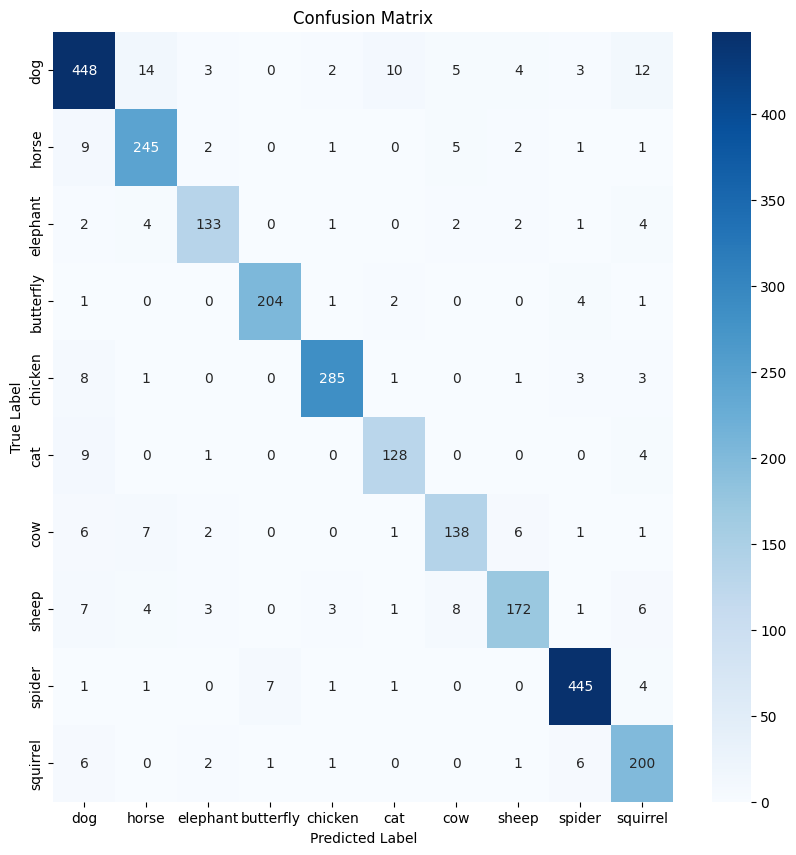

In [52]:

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions
predicted_batch = model.predict(test_ds)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)

# Get true labels
true_labels = []
for images, labels in test_ds:
  true_labels.extend(labels.numpy())

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_id)

# Display confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Precision, Recall and F1-Score

In [53]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_id, target_names=class_names)
print(report)

              precision    recall  f1-score   support

         dog       0.90      0.89      0.90       501
       horse       0.89      0.92      0.90       266
    elephant       0.91      0.89      0.90       149
   butterfly       0.96      0.96      0.96       213
     chicken       0.97      0.94      0.95       302
         cat       0.89      0.90      0.90       142
         cow       0.87      0.85      0.86       162
       sheep       0.91      0.84      0.88       205
      spider       0.96      0.97      0.96       460
    squirrel       0.85      0.92      0.88       217

    accuracy                           0.92      2617
   macro avg       0.91      0.91      0.91      2617
weighted avg       0.92      0.92      0.92      2617

